# Import packages

### Import python packages

In [1]:
import re,os
os.environ["CUDA_VISIBLE_DEVICES"]="5"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output
import pandas as pd
import math
import random
from datetime import datetime
from scipy.stats import linregress
from sklearn.decomposition import PCA
from tqdm import trange, tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import scipy
from scipy import interpolate
tfk = tf.keras
tfkl = tf.keras.layers
clear_output()

### Import custom packages

In [2]:
from MRA_generate import MRA_generate
from symae_model import SymAE
from parameters import *
from redatuming import redatuming
from latent import latent
from plot_training import plot_training
from plot_redatuming import plot_redatuming
from plot_save import plot_save
import symae_core as symae

# Generate dataset X

### Define $n_\varepsilon$ states

In [3]:
def g(n,x):
    if n==1:
        return int(x<0.5)
    elif n==2:
        return math.e**(-9*(x)**2)
    elif n==0:
        return math.cos(2*math.pi*x)

Text(0.5, 0.98, 'Show the shape of all $n_\\epsilon$ = 3 states')

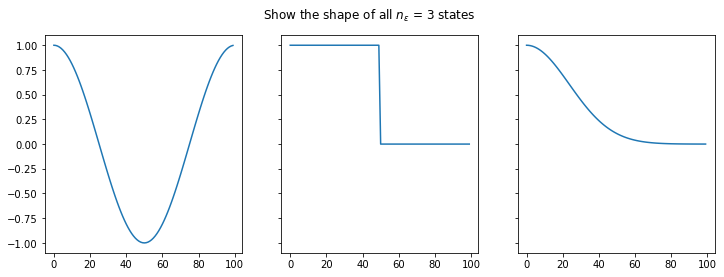

In [4]:
fig, axs = plt.subplots(1, ne, sharex=True, sharey=True, figsize=(ne*4, 4))
for i in range(ne):
    axs[i].plot(range(d), [g(i,x/d) for x in range(d)])
plt.suptitle('Show the shape of all $n_\epsilon$ = %d states'%ne)

### Generate the dataset

In [5]:
MRA_training = MRA_generate(d,nt,N,sigma,ne,g,replace=0,continuous=False)

In [6]:
MRA_training.generate_default()
X = MRA_training.X

In [7]:
states = MRA_training.states
shifts = MRA_training.shifts

### Print the structure of dataset X

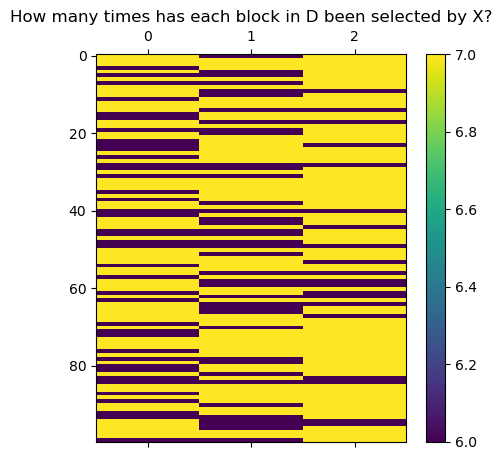

In [8]:
select_times = MRA_training.select_times
plt.figure(figsize=(5,5),dpi=100)
plt.matshow(select_times.T, aspect='auto', fignum=1)
plt.colorbar()
plt.title('How many times has each block in D been selected by X?')
plt.show()

# Train SymAE

In [9]:
class SymAE(tf.keras.Model):
    def __init__(self,N=1000,nt=20,d=100,p=8,q=22,w=100,dropout_rate=0.65): 
        super(SymAE, self).__init__()
        # Build symmetric encoder
        sym_encoder=symae.SymmetricEncoderDense1D(p,w)
        self.sym_encoder=sym_encoder
        
        # Build nuisance encoder
        nui_encoder=symae.NuisanceEncoderDense1D(q,w)
        self.nui_encoder=nui_encoder
        
        # Build distribute in decoder
        distzsym = symae.DistributeZsym(nt, p, q)
        self.distzsym = distzsym
        
        #Build mixer in decoder
        mixer = symae.MixerDense1D(d,w)
        self.mixer = mixer
        
        # Build latentcat
        latentcat = symae.MyLatentCat(alpha=dropout_rate)
        self.latentcat = latentcat        
        
        # Build encoder
        encoder_input = tfk.Input(shape=(nt,d), dtype='float32', name='encoder_input')
        znuisance = nui_encoder(encoder_input)
        zsym = sym_encoder(encoder_input)
        encoder_output=latentcat(zsym,znuisance)
        encoder=tfk.Model(encoder_input, encoder_output, name="encoder")
        self.encoder=encoder
        
        # Build decoder
        decoder_input = tfk.Input(shape=(p+q*nt), name='latentcode')
        decoder_output=mixer(distzsym(decoder_input))
        decoder=tfk.Model(decoder_input,decoder_output, name="decoder") 
        self.decoder=decoder
        
    def call(self, x):
        sym_code = self.sym_encoder(x)
        nui_code = self.nui_encoder(x)
        z = self.latentcat(sym_code, nui_code)
        dist = self.distzsym(z)
        out = self.mixer(dist)
        return out

### Initialize SymAE and load weights

In [10]:
model = SymAE(N,nt,d,p,q,1000,0.5)
model.load_weights('./checkpoint/'+'p=%d,q=%d,ne=%d'%(p,q,ne))
clear_output()

In [11]:
model.latentcat.drop.rate = 0.5

### Train the NeuralNet

In [12]:
optimizer = tf.keras.optimizers.Adam(0.001)
mse = tf.keras.losses.MeanSquaredError()

In [13]:
def reconstruction_loss(model, x, training=False):
    x_hat = model(x, training=True)
    return mse(x, x_hat)
@tf.function
def train_step(model, x, training=True):
    with tf.GradientTape() as tape:
        loss_rec = reconstruction_loss(model, x, training)
        loss = loss_rec
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [14]:
for epoch in range(10):
    loss = train_step(model, X)
    print("For epoch {:d}, reconstruction loss is {:f}."
          .format(epoch, loss))
    clear_output(wait=True)

For epoch 9, reconstruction loss is 0.018023.


### Save weights

In [15]:
model.save_weights('./checkpoint/p=%d,q=%d,ne=%d'%(p,q,ne))
print("weights saved")

weights saved


# Redatuming

In [16]:
def find(state,nuisance):
    MRA_data = MRA_generate(d,nt,1,sigma,ne,g,replace=1)
    for i in range(1000):
        MRA_data.generate_default()
        if MRA_data.states[0] != state:
            continue
        for j in range(nt):
            if MRA_data.shifts[0][j] == nuisance:
                return MRA_data, j

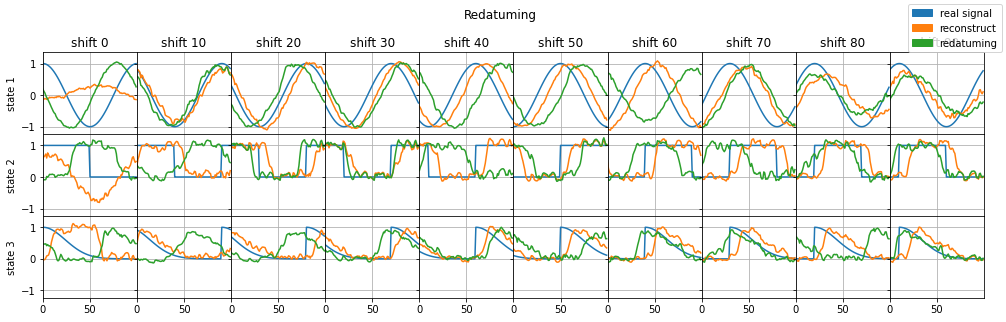

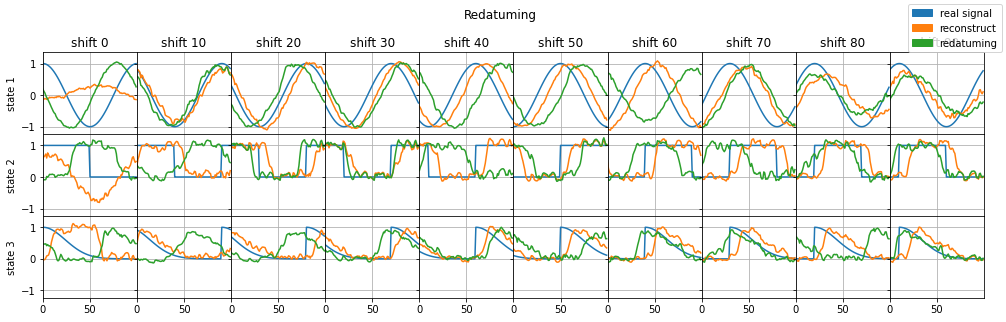

In [17]:
from movie_redatum import movie_redatum
movie_redatum(g,model)

### Choose which 2 states and shifts you want to redatum 

In [18]:
MRA1, t1 = find(0,0)
MRA2, t2 = find(1,0)

### Redatuming and the visualize it

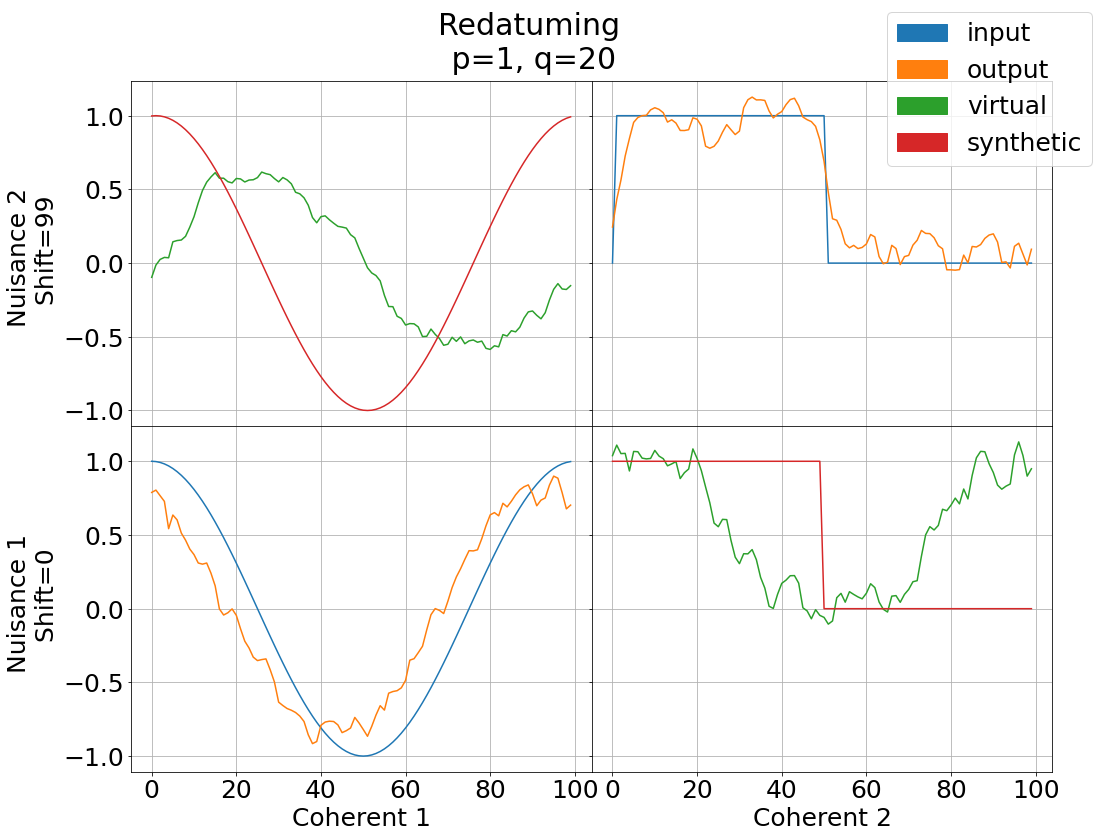

In [19]:
redatum = redatuming(model,MRA1,MRA2,t1,t2)
#redatum = redatuming(model,MRA_training,MRA_training,0,0)
MSE_C1_N2, MSE_C2_N1 = redatum.MSE()
fig = plot_redatuming(redatum)
clear_output()
print('The MSE of C1N2 is: %f'%MSE_C1_N2)
print('The MSE of C2N1 is: %f'%MSE_C2_N1)
for i in range(100):
    MRA1, t1 = find(0,0)
    MRA2, t2 = find(1,i)
    fig = plot_redatuming(redatuming(model,MRA1,MRA2,t1,t2))
    clear_output(wait=True)
    plt.show()

### List many redatuming

In [20]:
def dec(latent_code):
    tem = latent_code[np.newaxis, np.newaxis, :]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.mixer.predict(tem, verbose=0)
    return tem[0,0,:]
def enc(state, shift):
    MRA1, t1 = find(state,shift)
    tem = model.encoder(MRA1.X)
    return tf.concat([tem[0,0:p], tem[0,t1*q+p:(t1+q)*q+p]], axis=0)

100%|█████████████████████████████████████████| 100/100 [00:30<00:00,  3.28it/s]


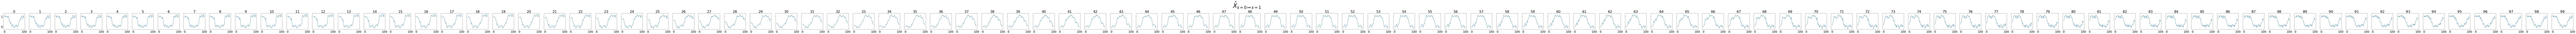

In [21]:
if 1==1:
    state_source = 1
    nuisance_source = 0
    fig, axs = plt.subplots(1, d, sharex=True, sharey=True, figsize=(4*d,4), dpi=40)
    for i in trange(d):
        coherent_code = enc(state_source, i)[0: p]
        nuisance_code = enc(nuisance_source, i)[p: p+q]
        latent_code = np.concatenate([coherent_code, nuisance_code], axis=0)
        axs[i].plot(range(d), dec(latent_code))
        axs[i].set_title('%d'%i)
    plt.suptitle('$\hat{X}_{s=%d \mapsto s=%d}$'%(nuisance_source, state_source), fontsize=50)
    plt.subplots_adjust(top=0.6)
    plt.show()

# Latent functions

In [22]:
MRA_test = MRA_generate(d,nt,100,sigma,ne,g,replace=0,continuous=False)
MRA_test.generate_default()
clear_output()
N_code = model.nui_encoder.predict(MRA_test.X,verbose=0)
N_reshaped = N_code.reshape(-1,q)
N_states = np.repeat(MRA_test.states,nt)
N_shifts = MRA_test.shifts.reshape(-1,1)
s_sub = [N_states==s for s in range(ne)]
C_code = model.sym_encoder.predict(MRA_test.X,verbose=0)
C_reshaped = C_code.reshape(-1,p)

### Nuisance space

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 33.10it/s]


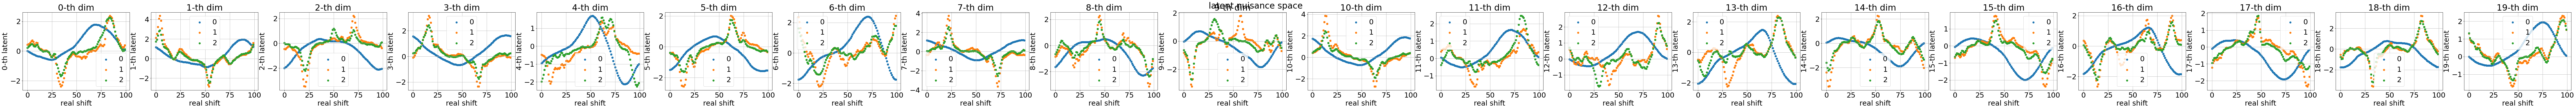

In [23]:
fig, axs = plt.subplots(1, q, figsize=(q*8,5))
for i in trange(q):
    for s in range(ne):
        axs[i].scatter(N_shifts[s_sub[s]],N_reshaped[:,i][s_sub[s]],color='C%d'%s,label=s)
        axs[i].set_title('%d-th dim'%i)
        axs[i].set_xlabel('real shift')
        axs[i].set_ylabel('%d-th latent'%i)
        axs[i].legend()
        axs[i].grid()
fig.suptitle('latent nuisance space')
fig.show()

In [24]:
pca_N = PCA(3).fit_transform(N_reshaped)
df = pd.DataFrame(pca_N, columns = ['1st','2nd','3rd'])
df_states = pd.DataFrame(N_states,columns=['state']).astype('object')
df_shifts = pd.DataFrame(N_shifts,columns=['shift'])
df = pd.concat([df,df_states,df_shifts],axis=1)
fig = px.scatter_3d(df, x='1st', y='2nd', z='3rd', color='state')
fig.show()

### Coherent space

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 114.31it/s]


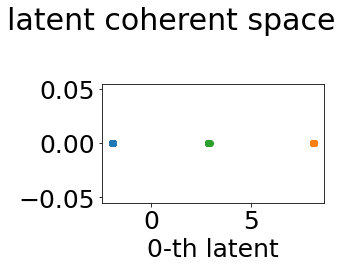

In [25]:
axs=[0]
fig, axs[0] = plt.subplots(1, p, sharex=True, sharey=True, figsize=(p*5,4))
for i in trange(p):
    for s in range(ne):
        axs[i].scatter(C_reshaped[:,i][MRA_test.states==s],np.zeros(sum(MRA_test.states==s)),color='C%d'%s)
        axs[i].set_xlabel('%d-th latent'%i)
fig.suptitle('latent coherent space')
fig.tight_layout()
fig.show()